In [1]:
from collections import Counter
from tqdm import tqdm
import pandas as pd
import re

%matplotlib notebook
tqdm.pandas()

In [2]:
df = pd.read_csv('PADCHEST_chest_x_ray_images_labels_160K.csv', 
                 low_memory=False).drop(columns='Unnamed: 0')
df.columns

Index(['ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID', 'PatientID',
       'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM', 'Projection',
       'MethodProjection', 'Pediatric', 'Modality_DICOM', 'Manufacturer_DICOM',
       'PhotometricInterpretation_DICOM', 'PixelRepresentation_DICOM',
       'PixelAspectRatio_DICOM', 'SpatialResolution_DICOM', 'BitsStored_DICOM',
       'WindowCenter_DICOM', 'WindowWidth_DICOM', 'Rows_DICOM',
       'Columns_DICOM', 'XRayTubeCurrent_DICOM', 'Exposure_DICOM',
       'ExposureInuAs_DICOM', 'ExposureTime', 'RelativeXRayExposure_DICOM',
       'ReportID', 'Report', 'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [3]:
# Check which rows are identical to each other, save for the image filename (ImageID)
print(df.duplicated(subset=df.columns[1:]).sum()) 
# Out[3] = 986
# It's possible that these are the same image with just different filenames

# Remove these duplicate rows
df = df.drop_duplicates(subset=df.columns[1:])

# Remove missing labels
print(df.Labels.isna().sum())
df = df.dropna(subset=['Labels'])

986
103


In [6]:
df.shape

(159772, 35)

In [4]:
len(set(df.StudyID))

109852

In [5]:
len(set(df.PatientID))

67594

# Labels

In [4]:
print(df.Labels[:5])

0                                           ['normal']
1    ['pulmonary fibrosis', 'chronic changes', 'kyp...
2    ['pulmonary fibrosis', 'chronic changes', 'kyp...
3                                  ['chronic changes']
4                                  ['chronic changes']
Name: Labels, dtype: object


Converting labels to CXR8 format, ie, from 

`"['alveolar pattern', 'interstitial pattern', 'pneumonia']"` 

to 

`alveolar pattern|interstitial pattern|pneumonia`

In [5]:
def list_to_str(raw):
    raw = [x.strip() for x in eval(raw)]
    return "|".join(raw)

def raw_label_counts(x):
    return pd.DataFrame(Counter("|".join(x).split("|")).most_common(),columns=['label', 'counts'])

df.Labels = df.Labels.apply(list_to_str)
df.Labels[:5]

0                                               normal
1    pulmonary fibrosis|chronic changes|kyphosis|ps...
2    pulmonary fibrosis|chronic changes|kyphosis|ps...
3                                      chronic changes
4                                      chronic changes
Name: Labels, dtype: object

In [6]:
padchest_label_counts = raw_label_counts(df.Labels)
padchest_label_counts

,label,counts
0,normal,50229
1,COPD signs,23197
2,cardiomegaly,14958
3,unchanged,14296
4,aortic elongation,10790
5,pleural effusion,9972
6,scoliosis,8292
7,pneumonia,7948
8,interstitial pattern,7786
9,chronic changes,7332


In [7]:
# There are some labels in padchest that are more descriptive than 
# the mostly single-word labels in CXR8. Finding and listing those labels

cxr_labels = ['pneumonia', 'effusion', 'consolidation', 'no finding', 'cardiomegaly', 
         'infiltration', 'emphysema', 'mass', 'hernia', 'atelectasis', 
         'pneumothorax', 'edema', 'pleural thickening', 'nodule', 'fibrosis']
cxr8 = re.compile("|".join(cxr_labels))
pd.DataFrame([(x, cxr8.search(x).group()) for x in padchest_label_counts.label if cxr8.search(x) and x not in cxr_labels],
             columns=['Original_label', 'CXR_equivalent'])


,Original_label,CXR_equivalent
0,pleural effusion,effusion
1,laminar atelectasis,atelectasis
2,apical pleural thickening,pleural thickening
3,hiatal hernia,hernia
4,pseudonodule,nodule
5,pulmonary edema,edema
6,pulmonary fibrosis,fibrosis
7,pulmonary mass,mass
8,lobar atelectasis,atelectasis
9,calcified pleural thickening,pleural thickening


In [8]:
# Converting PadChest labels to CXR8 labels
# 'No finding' if it has either 'normal' or none of the 14 CXR8 labels

def convert_to_cxr8_labels(x):
    match = set(cxr8.findall(x))
    new_label = "|".join(match) if match else 'no finding'
    return new_label

df.Labels = df.Labels.apply(convert_to_cxr8_labels)
raw_label_counts(df.Labels)

,label,counts
0,no finding,109556
1,cardiomegaly,14952
2,effusion,9973
3,atelectasis,8913
4,pneumonia,8083
5,nodule,6213
6,pleural thickening,5139
7,consolidation,2480
8,hernia,2354
9,emphysema,1728


In [9]:
raw_label_counts(df.Labels).iloc[1:].sum()

label     cardiomegalyeffusionatelectasispneumonianodule...
counts                                                64568
dtype: object

In [10]:
df['number_of_labels'] = df.Labels.apply(lambda x: len(x.split("|")))
df.number_of_labels.value_counts()

1    147770
2      9920
3      1843
4       210
5        29
Name: number_of_labels, dtype: int64

# Views

In [11]:
df.Projection.value_counts()

PA               91197
L                49230
AP_horizontal    14209
AP                4500
COSTAL             617
EXCLUDE             11
UNK                  8
Name: Projection, dtype: int64

In [17]:
nviews = df.groupby('StudyID').Projection.progress_apply(lambda x: len(set(x)))
nviews = nviews > 1
df['More than one view?'] = df.StudyID.map(nviews)
df['Pathology'] = df.Labels.apply(lambda x: 'no finding' if x=='no finding' else 'pathology present')

100%|██████████| 109852/109852 [00:07<00:00, 14057.53it/s]


<IPython.core.display.Javascript object>


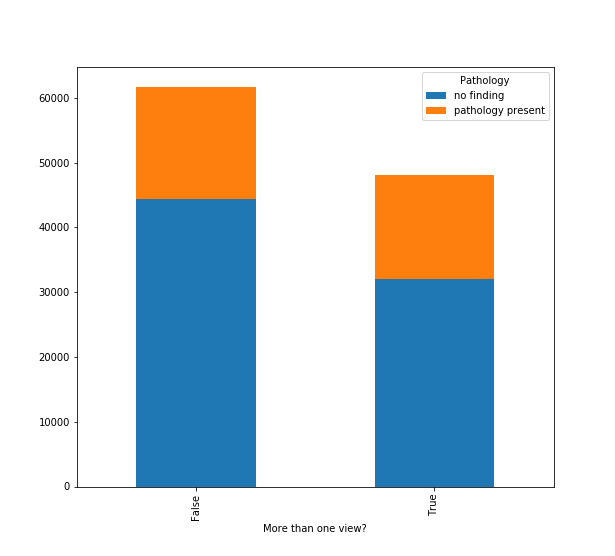

In [37]:
x = df.drop_duplicates('StudyID')
pd.crosstab(x['More than one view?'], x['Pathology']).plot.bar(stacked=True)

In [15]:
nviews = df.groupby('PatientID').Projection.progress_apply(lambda x: len(set(x)))
nviews = nviews > 1
df['More than one view?'] = df.PatientID.map(nviews)


100%|██████████| 67594/67594 [00:04<00:00, 14005.18it/s]


<IPython.core.display.Javascript object>


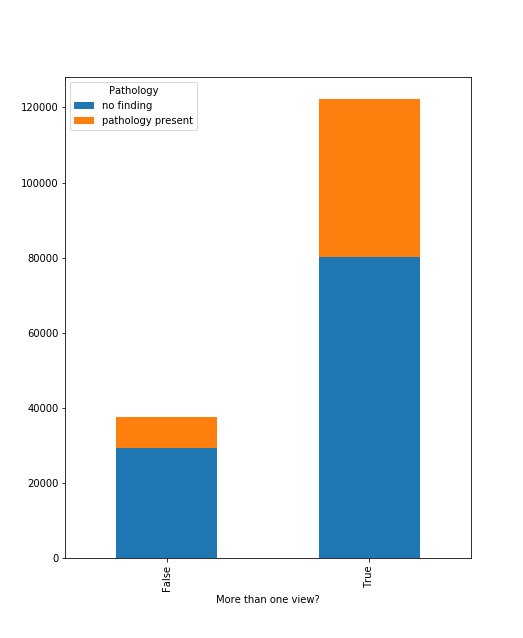

In [16]:
pd.crosstab(df['More than one view?'], df['Labels']).plot.bar(stacked=True)

In [19]:
# Generating crosstab between labels and projections.
projs = df[['Labels', 'More than one view?']].copy()
s = projs['Labels'].str.split('|').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'Labels'
projs = projs.drop(columns='Labels').join(s)

In [29]:
ct = pd.crosstab(projs.Labels, projs['More than one view?'])
ct

More than one view?,False,True
Labels,,
atelectasis,3466,5447
cardiomegaly,4842,10110
consolidation,856,1624
edema,1134,313
effusion,4108,5865
emphysema,463,1265
fibrosis,225,998
hernia,890,1464
mass,347,1153


<IPython.core.display.Javascript object>


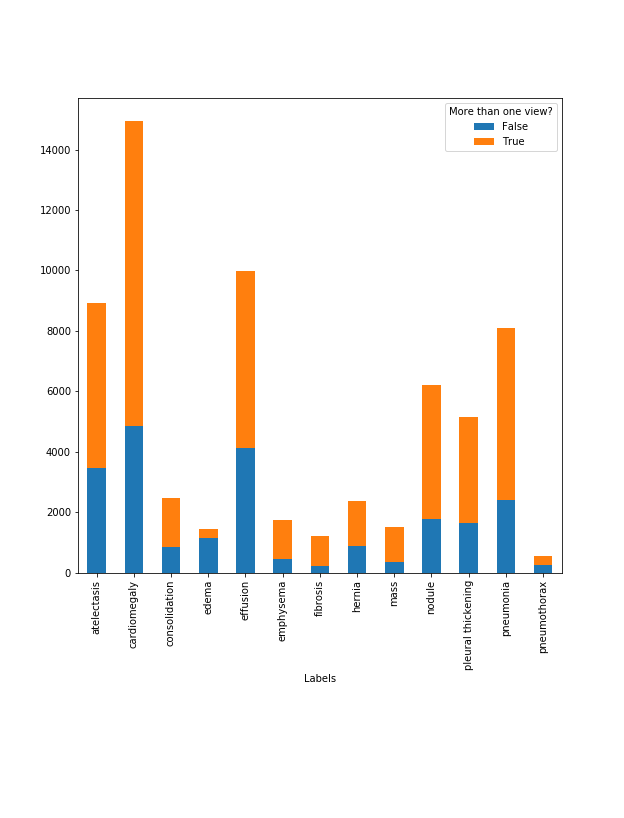

In [30]:
plt = ct.drop('no finding').plot.bar(stacked=True)

<IPython.core.display.Javascript object>


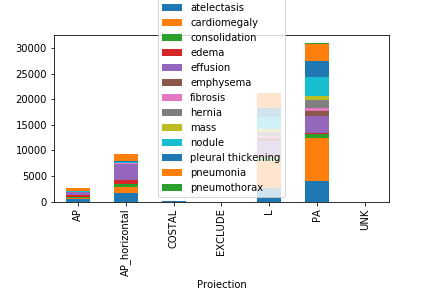

In [15]:
ct = pd.crosstab(projs.Projection,projs.Labels)
plt = ct.drop('no finding', axis=1).plot.bar(stacked=True)

In [31]:
fig = plt.get_figure()
fig.subplots_adjust(bottom=0.3)

fig.savefig("output1.png")


In [17]:
df.groupby('PatientID').Projection.progress_apply(lambda x: ", ".join(sorted(set(x)))).value_counts()

100%|██████████| 67594/67594 [00:05<00:00, 13400.34it/s]


L, PA                               32176
PA                                  25626
AP_horizontal                        3199
AP_horizontal, L, PA                 1471
AP_horizontal, PA                    1287
AP                                   1259
AP, L, PA                             413
AP, AP_horizontal                     385
AP, AP_horizontal, L, PA              362
AP, PA                                302
L                                     299
AP, AP_horizontal, PA                 231
COSTAL, L, PA                         165
AP, L                                 130
AP_horizontal, L                       99
COSTAL                                 75
COSTAL, PA                             43
AP_horizontal, COSTAL, L, PA           17
AP, AP_horizontal, L                   16
AP, EXCLUDE, L, PA                      7
AP, COSTAL, L, PA                       5
AP_horizontal, COSTAL                   4
L, PA, UNK                              4
AP, COSTAL                        

In [34]:
# Number of StudyIDs/PatientIDs that have 1 view, 2 views etc. 
# Probably, patientIDs might be wrong as other types of views may be from different dates?
df.groupby('StudyID').Projection.progress_apply(lambda x: len(set(x))).value_counts()


100%|██████████| 109852/109852 [00:08<00:00, 12754.91it/s]

1    61715
2    47953
3      180
4        4
Name: Projection, dtype: int64

 36%|███▌      | 39103/109852 [00:20<00:05, 13802.21it/s]

proportion of patients that have no disease among patients with one view only, vs patients with multiple view ?

In [19]:
df.groupby('PatientID').Projection.progress_apply(lambda x: len(set(x))).value_counts()

100%|██████████| 67594/67594 [00:04<00:00, 13850.16it/s]


2    34435
1    30458
3     2305
4      392
5        4
Name: Projection, dtype: int64